In [318]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from moviepy.video.io.bindings import mplfig_to_npimage

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [56]:
data_dir = '/scratch/shantanu/gibson4/new'
bev_dir = '/scratch/shantanu/gibson4/new_partialmaps_120'
# bev_dir = '/scratch/shantanu/gibson4/new'
semantic_dir = '/scratch/shantanu/gibson4/semantics'

print(os.listdir(data_dir))

['Sisters', 'Shelbiana', 'Azusa', 'Nuevo', 'Crandon', 'Quantico', 'Sands', 'Convoy', 'Springhill', 'Roxboro', 'Hometown', 'Elmira', 'Kerrtown', 'Pablo', 'Hambleton', 'Pleasant', 'Andover', 'Sanctuary', 'Sargents', 'Delton', 'Colebrook', 'Stilwell', 'Scioto', 'Bolton', 'Hainesburg', 'Mobridge', 'Reyno', 'Silas', 'Monson', 'Sasakwa', 'Swormville', 'Nicut', 'Goffs', 'Roeville', 'Cooperstown', 'Soldier', 'Rancocas', 'Sodaville', 'Woonsocket', 'Spencerville', 'Albertville', 'Adrian', 'Mesic', 'Eastville', 'Mifflintown', 'Cantwell', 'Oyens', 'Ribera', 'Ballou', 'Rosser', 'Denmark', 'Edgemere', 'Hillsdale', 'Superior', 'Applewold', 'Dunmor', 'Annawan', 'Sumas', 'Brevort', 'Roane', 'Bowlus', 'Spotswood', 'Capistrano', 'Scottsmoor', 'Eudora', 'Arkansaw', 'Mosinee', 'Pettigrew', 'Parole', 'Micanopy', 'Stanleyville', 'Beach', 'Haxtun', 'Avonia', 'Maryhill', 'Eagerville', 'Anaheim', 'Dryville', 'Angiola', 'Stokes', 'Sawpit', 'Placida', 'Nimmons', 'Nemacolin', 'Seward', 'Mosquito', 'Greigsville', '

In [57]:
floor_semantic_classes = (3, 28)

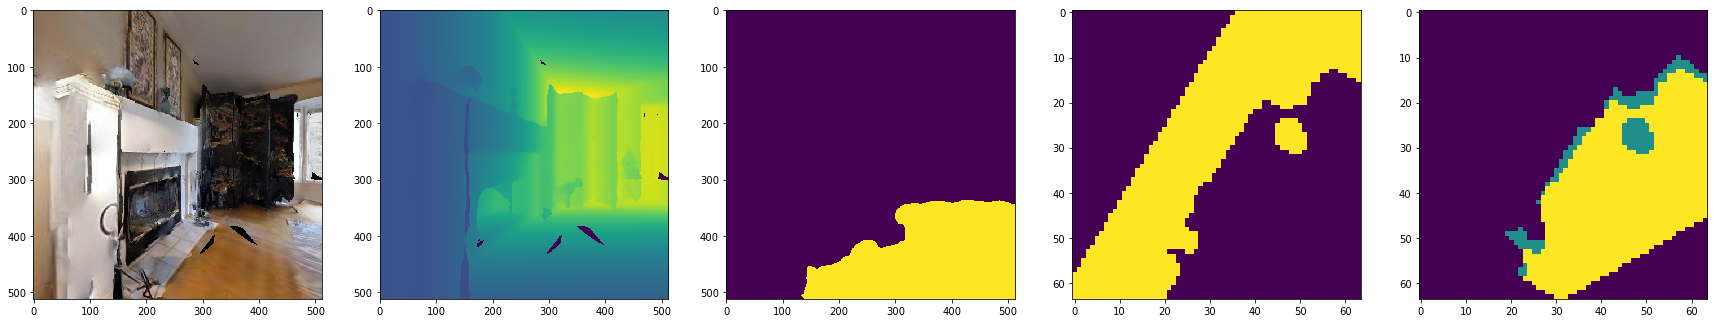

In [307]:
scene = 'Adrian'
fileidx = 75 #33

img_shape = (512, 512) #(128, 128) # w, h
bev_shape = (64, 64)

rgb_fp = os.path.join(data_dir, scene, '0', 'front', 'RGB', f'{fileidx}.jpg')
depth_fp = os.path.join(data_dir, scene, '0', 'front', 'DEPTH', f'{fileidx}.png')
sem_fp = os.path.join(semantic_dir, scene, '0', 'front', 'semantics', f'{fileidx}.png')
partial_occ_fp = os.path.join(bev_dir, scene, 'front', 'partial_occ', f'{fileidx}.png')
bev_fp = os.path.join(data_dir, scene, '0', 'front', 'map', f'{fileidx}.png')

rgb = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
sem = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0
partial_occ = cv2.imread(partial_occ_fp, -1)[64:, 32:96]
bev = cv2.imread(bev_fp, -1)[64:, 32:96]

width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
rgb = cv2.resize(rgb, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
rgb = rgb[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
sem = cv2.resize(sem, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
sem = sem[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
partial_occ = cv2.resize(partial_occ, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)
bev = cv2.resize(bev, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)


fig, ax = plt.subplots(ncols=5, figsize=(30, 6))
ax[0].imshow(rgb, interpolation='NEAREST')
ax[1].imshow(depth, interpolation='NEAREST')
ax[2].imshow(sem, interpolation='NEAREST')
ax[3].imshow(bev, interpolation='NEAREST')
ax[4].imshow(partial_occ, interpolation='NEAREST')

In [308]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect( u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)


    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

In [309]:
cam_height = 1.0
w, h = sem.shape
org_shape = (1024, 1024)

f = (org_shape[0] * h) / (2 * org_shape[1])

K = camera_intrinsic_transform(f_x=f, c_x=w/2, f_y=f, c_y=h/2)

inv_K = np.linalg.inv(K[:3,:3])

img_rect = np.array([*np.meshgrid(np.arange(w), np.arange(h)), np.ones((w, h))])

pc_proj = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))

# cos_theta = pc_proj[1] / np.linalg.norm(pc_proj, ord=2, axis=0)
# sin_theta = np.sqrt(1 - cos_theta**2)

# depth_pred = cam_height * sin_theta / (cos_theta + 1e-6)

depth_pred = (cam_height * f / (img_rect[1] - h/2 + 1e-6)) #[np.newaxis, :]

pc = pc_proj * depth_pred
# pc = pc.transpose((0,2,1))
pc_valid = pc * sem

pc_valid = np.concatenate([pc_valid, np.ones((1, h, w))], axis=0)

In [310]:
def get_seg_map(depth, bev):
    inv_K = np.linalg.inv(K[:3,:3])

    img_rect = np.array([*np.meshgrid(np.arange(w), np.arange(h)), np.ones((w, h))])

    pc = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc = pc * depth
    pc = pc.reshape((3, -1))

    pc = np.concatenate([pc, np.ones((1, h*w))], axis=0)

    bev_size = (3.2, 3.2) # m
    bev_res = bev_size[0] / bev.shape[0]
    
    cam_to_agent = np.eye(4)

    T = np.zeros((4, 4))
    T[0,0] = 1
    T[1,2] = -1
    T[2,1] = 1
    T[3,3] = 1
    T[0,3] = 1.6
    T[1,3] = 3.2

    ortho_cam_points = (T @ cam_to_agent @ pc) // bev_res
    valid = (ortho_cam_points[0] >= 0) & (ortho_cam_points[0] < bev.shape[1]) & (ortho_cam_points[1] >= 0) & (ortho_cam_points[1] < bev.shape[0]) & (ortho_cam_points[2] >= 0)

    pt_bev_indices = (ortho_cam_points[1, valid]*bev.shape[1] + ortho_cam_points[0, valid]).astype(int)
    pt_bev_cls = np.take(bev.reshape(-1), pt_bev_indices)

    seg_map = np.zeros(w * h, dtype=np.uint8)
    seg_map[valid] = pt_bev_cls
    seg_map = seg_map.reshape((h, w))
    
    return seg_map

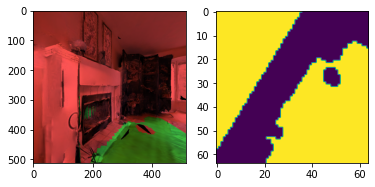

In [311]:
bev_seg = get_seg_map(depth, 255-bev)//255
overlay = np.copy(rgb) // 3
overlay[bev_seg==0, 0] *= 3
overlay[bev_seg==1, 1] *= 3

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(overlay)
ax[1].imshow(255-bev)

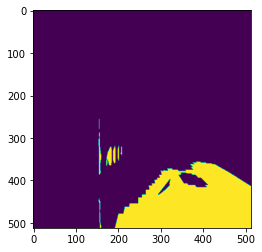

In [313]:
plt.imshow(bev_seg)

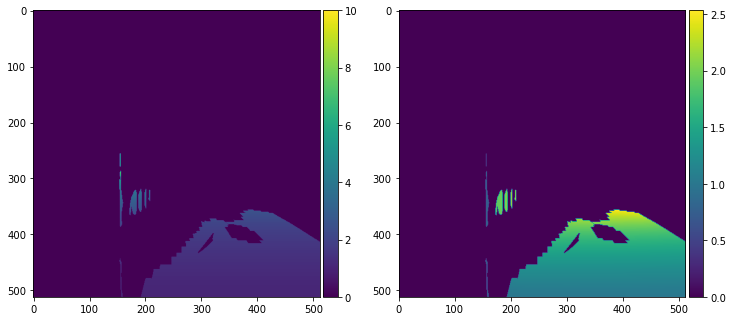

In [324]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
# ax[0].imshow(depth_pred.transpose(1, 0) * sem)
# ax[1].imshow(depth * sem)
im0 = ax[0].imshow(np.clip(depth_pred * bev_seg, a_min=0, a_max=10))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')


im1 = ax[1].imshow(depth * bev_seg)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

# plt.colorbar(ax[0])
# ax[1].colorbar()

0.008131274509344418 0.14749298580355422


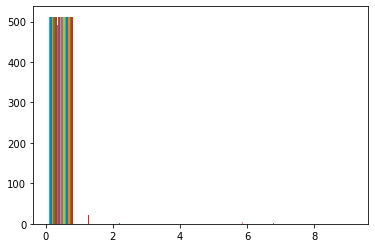

In [325]:
diff = (np.clip(depth_pred * bev_seg, a_min=0, a_max=10)) - (depth * bev_seg)
# diff = diff[bev_seg!=0]
# diff = diff.reshape(-1)
plt.hist(diff)

print(np.mean(np.abs(diff)), np.std(np.abs(diff)))

In [326]:
np.median(np.clip(depth_pred * bev_seg, a_min=0, a_max=10)[bev_seg!=0]), np.median((depth*bev_seg)[bev_seg!=0])

(1.299492379190394, 1.2860304)

In [327]:
np.median((depth_pred * bev_seg)[bev_seg!=0]) / np.median((depth*bev_seg)[bev_seg!=0])

1.0104678453537586

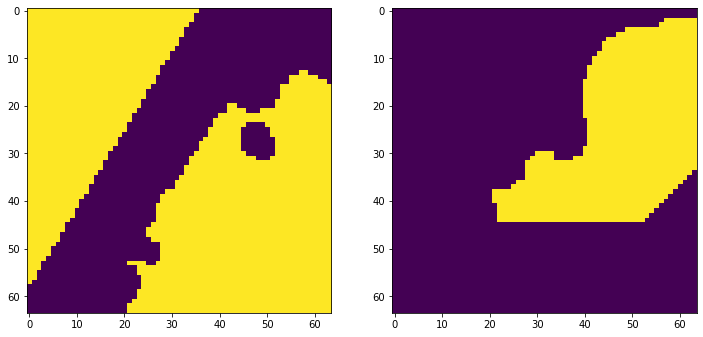

In [332]:
V = 64
Vby2 = V // 2

map_scale = 0.05

pc = pc_proj * np.clip(depth_pred, a_min=0, a_max=10)
pc_valid = pc * sem
pc_valid = np.concatenate([pc_valid, np.ones((1, h, w))], axis=0)

points = pc_valid.reshape((4, -1)).transpose((1, 0))
points[:, 1] *= -1
points[:, 2] *= -1

grid_x = ((points[:, 0] / map_scale) + Vby2)
grid_y = ((points[:, 2] / map_scale) + V)

valid_idx = (
    (grid_x >= 0) & (grid_x <= V - 1) & (grid_y >= 0) & (grid_y <= V - 1)
)
points = points[valid_idx, :]
grid_x = np.round(grid_x[valid_idx]).astype(int)
grid_y = np.round(grid_y[valid_idx]).astype(int)

pred_bev = np.zeros((V, V), np.uint8)
pred_bev[grid_y, grid_x] = 1

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(255-bev, interpolation='nearest')
ax[1].imshow(pred_bev, interpolation='nearest')

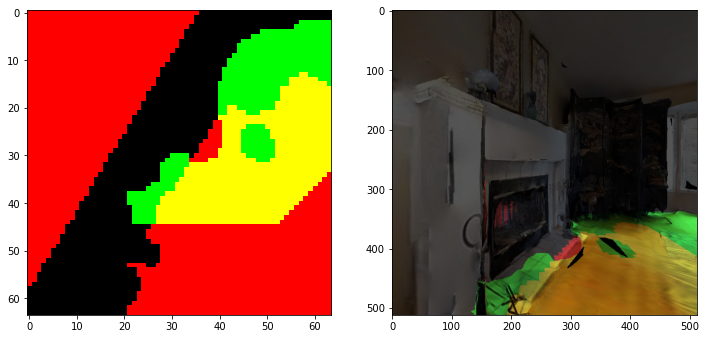

In [333]:
tmp = np.zeros((64, 64, 3), dtype=np.uint8)
tmp[bev==0,0] = 255
tmp[pred_bev==1, 1] = 255

tmp2 = np.copy(rgb) // 3
tmp2[bev_seg==1,0] *= 3
tmp2[sem==1, 1] *= 3

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(tmp)
ax[1].imshow(tmp2)

## Quantitative evaluation

In [338]:
cam_height = 1.0
w, h = sem.shape
org_shape = (1024, 1024)

f = (org_shape[0] * h) / (2 * org_shape[1])

K = camera_intrinsic_transform(f_x=f, c_x=w/2, f_y=f, c_y=h/2)

inv_K = np.linalg.inv(K[:3,:3])

img_rect = np.array([*np.meshgrid(np.arange(w), np.arange(h)), np.ones((w, h))])

pc_proj = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))

# cos_theta = pc_proj[1] / np.linalg.norm(pc_proj, ord=2, axis=0)
# sin_theta = np.sqrt(1 - cos_theta**2)

# depth_pred = cam_height * sin_theta / (cos_theta + 1e-6)

depth_pred = (cam_height * f / (img_rect[1] - h/2 + 1e-6)) #[np.newaxis, :]

pc = pc_proj * depth_pred
# pc = pc.transpose((0,2,1))
pc_valid = pc * sem

pc_valid = np.concatenate([pc_valid, np.ones((1, h, w))], axis=0)

In [339]:
def save_map(pts, filepath):
    V = 64
    Vby2 = V // 2

    map_scale = 0.05

    points = pts.reshape((3, -1)).transpose((1, 0))
    points[:, 1] *= -1
    points[:, 2] *= -1

    grid_x = ((points[:, 0] / map_scale) + Vby2)
    grid_y = ((points[:, 2] / map_scale) + V)

    valid_idx = (
        (grid_x >= 0) & (grid_x <= V - 1) & (grid_y >= 0) & (grid_y <= V - 1)
    )
    points = points[valid_idx, :]
    grid_x = np.round(grid_x[valid_idx]).astype(int)
    grid_y = np.round(grid_y[valid_idx]).astype(int)

    pred_bev = np.zeros((V, V), np.uint8)
    pred_bev[grid_y, grid_x] = 1
    
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    cv2.imwrite(filepath, pred_bev * 254)

In [340]:
def get_pred_diff(data_dir, scene, fileidx, out_dir=None):
    depth_fp = os.path.join(data_dir, scene, '0', 'front', 'DEPTH', f'{fileidx}.png')
    sem_fp = os.path.join(semantic_dir, scene, '0', 'front', 'semantics', f'{fileidx}.png')

    sem = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0
    scale_width = int(sem.shape[1] * h / sem.shape[0])
    sem = cv2.resize(sem, dsize=(scale_width, h), interpolation=cv2.INTER_NEAREST)
    sem = sem[:h, (scale_width - w)//2 : (scale_width + w)//2]
    
    depth_gt = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
    depth_gt = cv2.resize(depth_gt, dsize=(scale_width, h), interpolation=cv2.INTER_NEAREST)
    depth_gt = depth_gt[:h, (scale_width - w)//2 : (scale_width + w)//2]
    
    pc = pc_proj * depth_pred
    pc_valid = pc * sem
    
    if out_dir is not None:
        depth_savepath = os.path.join(out_dir, scene, '0', 'front', 'pred_depth', f'{fileidx}.png')
        os.makedirs(os.path.dirname(depth_savepath), exist_ok=True)
        pred_depth = (np.clip((depth_pred * sem) * 6553.5, a_min=0, a_max=65535)).astype(np.uint16)
        cv2.imwrite(depth_savepath, pred_depth)
        
        save_map(np.copy(pc_valid), os.path.join(out_dir, scene, '0', 'front', 'pred_bev', f'{fileidx}.png'))
    
    diff = pc_valid[2] - (depth_gt * sem)
    diff = diff.reshape(-1)

    return np.mean(np.abs(diff))

In [341]:
# COMPUTE HEAVY

scene_errs = {}
scenes = os.listdir(data_dir)
out_dir = '/scratch/shantanu/gibson4/chandrakar'

for scene in scenes:
    errs = []
    for fileidx in range(len(os.listdir(os.path.join(data_dir, scene, '0', 'front', 'RGB')))):
        errs.append(get_pred_diff(data_dir, scene, fileidx, out_dir))
    scene_errs[scene] = errs

for scene, val in scene_errs.items():
    print(scene, np.percentile(val, [95, 97, 99]))

Sisters [0.00702989 0.01446451 0.0387211 ]
Shelbiana [0.05803869 0.0658383  0.07780044]
Azusa [0.08349371 0.09249545 0.12780827]
Nuevo [0.0382468  0.03958375 0.05273018]
Crandon [0.04024874 0.06394083 0.08230709]
Quantico [0.07265889 0.07714338 0.08306702]
Sands [0.23204832 0.24194014 0.25183196]
Convoy [0.02996992 0.03259528 0.0353555 ]
Springhill [0.07573005 0.08272516 0.10909419]
Roxboro [0.05179213 0.06125038 0.08014402]
Hometown [0.07270089 0.07739602 0.08221251]
Elmira [0.05966608 0.06881053 0.12460134]
Kerrtown [0.05389487 0.07032066 0.10408912]
Pablo [0.04590401 0.05101287 0.05359047]
Hambleton [0.06136824 0.06800709 0.0735843 ]
Pleasant [0.04307844 0.04732889 0.05592867]
Andover [0.06987977 0.1179538  0.14453641]
Sanctuary [0.08353785 0.0916302  0.12210228]
Sargents [0.05363137 0.05425647 0.06414027]
Delton [0.06709626 0.08253663 0.09517574]
Colebrook [0.08450695 0.09344464 0.110586  ]
Stilwell [0.07073454 0.07477345 0.08661726]
Scioto [0.08814669 0.23571907 0.40056471]
Bolton

Except Wainscott, all have relatively low mean errors.

In [10]:
def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")


def segm_size(segm):
    try:
        height = segm.shape[0]
        width = segm.shape[1]
    except IndexError:
        raise

    return height, width


def extract_masks(segm, cl, n_cl):
    h, w = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks


def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask


def mean_precision(eval_segm, gt_segm, n_cl):

    check_size(eval_segm, gt_segm)
    # cl, n_cl = extract_classes(gt_segm)
    cl = np.arange(n_cl)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)
    mAP = [0] * n_cl
    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        n_ij = np.sum(curr_eval_mask)
        if n_ij == 0 and np.sum(curr_gt_mask) == 0:
            mAP[i] = 1
        else:
            mAP[i] = n_ii / (float(n_ij) + 1e-6)
    # print(mAP)
    return mAP


def mean_IU(eval_segm, gt_segm, n_cl):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    # cl, n_cl = union_classes(eval_segm, gt_segm)
    # _, n_cl_gt = extract_classes(gt_segm)
    cl = np.arange(n_cl)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)

    return IU

In [15]:
bev_dir = '/scratch/shantanu/HabitatGibson/bevs/partial_occupancy'
pred_dir = '/scratch/shantanu/chandrakar2'

In [28]:
# COMPUTE HEAVY

scene_scores = {}
scene_filenames = {}
bev_size = (128, 128)

for scene in os.listdir(bev_dir):
    scene_mIU = []
    scene_mAP = []
    filenames = sorted(os.listdir(os.path.join(bev_dir, scene)), 
                       key=lambda x: int(os.path.splitext(x)[0]))
    
    valid_filenames = []
    for filename in filenames:
        gt_bev = cv2.imread(os.path.join(bev_dir, scene, filename), -1) // 127 
        gt_bev = cv2.resize(gt_bev, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
        
        if np.sum(gt_bev==2) / (bev_size[0] * bev_size[1]) < 0.1:
            continue
            
        valid_filenames.append(filename)
        
        pred_bev = cv2.imread(os.path.join(pred_dir, scene, '0', 'pred_bev', filename), -1) // 127
        pred_bev = cv2.resize(pred_bev, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
        
        scene_mIU.append(mean_IU(pred_bev, gt_bev, 3))
        scene_mAP.append(mean_precision(pred_bev, gt_bev, 3))
        
    scene_filenames[scene] = valid_filenames
        
    mIU = np.array(scene_mIU)
    mAP = np.array(scene_mAP)
    
    scene_scores[scene] = np.array([mIU, mAP]) #np.array(scores)

# median IU per scene
for scene in scene_scores:
    print(scene, np.median(scene_scores[scene][0, :, :], axis=0))

Onaga [0.50336297 0.         0.40667684]
Wiconisco [0.58851887 0.         0.52254936]
Hanson [0.49413594 0.         0.40802499]
Markleeville [0.56155901 0.         0.52536339]
Wainscott [0.54858998 0.         0.39881054]
Hiteman [0.63736264 0.         0.40321231]
Coffeen [0.47765751 0.         0.55434531]
Klickitat [0.46413492 0.         0.37754138]
Beechwood [0.50006902 0.         0.43952013]
Stockman [0.61740256 0.         0.56429417]
Lakeville [0.48757799 0.         0.43154731]
Tolstoy [0.48214691 0.         0.42360075]
Pomaria [0.56464458 0.         0.48202563]
Shelbyville [0.57629267 0.         0.42037073]
Pinesdale [0.49430044 0.         0.39391119]
Newfields [0.48391098 0.         0.50753812]
Cosmos [0.57806874 0.         0.5002193 ]
Marstons [0.48846487 0.         0.44581968]
Leonardo [0.54880944 0.         0.52196785]
Woodbine [0.53129395 0.         0.40519581]
Mifflinburg [0.54984809 0.         0.36410734]
Allensville [0.54017556 0.         0.47772729]
Corozal [0.53440284 0. 

(20444, 3)
[0.53105744 0.         0.43296753]


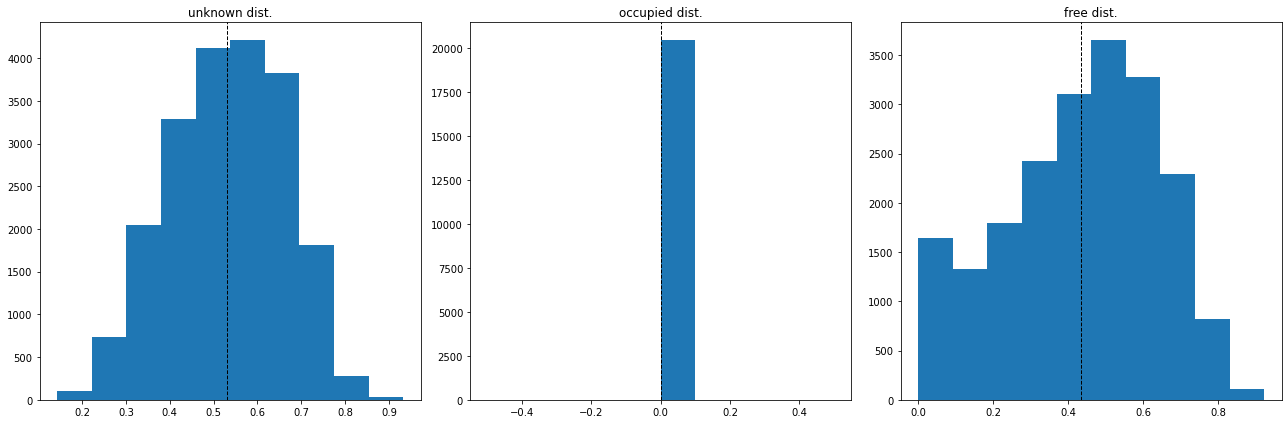

In [35]:
all_IU = np.empty((0, 3))
for scene in scene_scores:
    all_IU = np.concatenate([all_IU, scene_scores[scene][0, :, :]], axis=0)
    
print(all_IU.shape)
print(np.mean(all_IU, axis=0))
    
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

for idx, label in enumerate(['unknown', 'occupied', 'free']):
    ax[idx].hist(all_IU[:, idx])
    ax[idx].axvline(all_IU[:, idx].mean(), color='k', linestyle='dashed', linewidth=1)

    ax[idx].set_title(f'{label} dist.')

plt.tight_layout()
plt.show()

In [20]:
def compute_errors(gt, pred, mask=None):
    """Computation of error metrics between predicted and ground truth depths
    """
    if mask is None:
        mask = np.ones_like(gt) == 1
        
    gt = gt[mask]
    pred = pred[mask]
        
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [87]:
scene_depth_scores = {}
img_shape = (480, 480) 
bev_shape = (128, 128)
depth_range = (0.1, 10.0)

for scene in os.listdir(bev_dir):
    depth_scores = []
    
    for filename in scene_filenames[scene]:
        
        depth_fp = os.path.join(data_dir, scene, '0', 'left_depth', filename)
        sem_fp = os.path.join(data_dir, scene, '0', 'left_semantic', filename)
        
        depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
        floor_seg = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0

        width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
        depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
        depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
        floor_seg = cv2.resize(floor_seg, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
        floor_seg = floor_seg[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
            
        pred_depth = cv2.imread(os.path.join(pred_dir, scene, '0', 'pred_depth', filename), -1) / 6553.5
        pred_depth = cv2.resize(pred_depth, dsize=img_shape, interpolation=cv2.INTER_NEAREST)
        pred_depth = np.clip(pred_depth, a_min=depth_range[0], a_max=depth_range[1])

        mask = np.logical_and(floor_seg==1, depth>depth_range[0], depth<depth_range[1])
        
        if np.sum(mask) == 0:
            continue

        depth_scores.append(compute_errors(depth, pred_depth, mask))
        
    scene_depth_scores[scene] = np.array(depth_scores)

In [88]:
# median depth score per scene
data = []

for scene in scene_depth_scores.keys():
    if len(scene_depth_scores[scene]) > 0:
        scene_score = np.median(scene_depth_scores[scene], axis=0)
    else:
        scene_score = np.zeros(7)
    data.append([scene, len(scene_depth_scores[scene]), *scene_score])

df = pd.DataFrame(data, columns=['scene', 'len', 'abs_rel', 'sq_rel', 'rmse', 'rmse_log', 'a1', 'a2', 'a3'])
df.sort_values('a1', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:,.3f}'.format):  # more options can be specified also
    print(df)

           scene   len  abs_rel  sq_rel  rmse  rmse_log    a1    a2    a3
7      Klickitat  1047    0.332   0.498 1.158     1.125 0.609 0.835 0.863
4      Wainscott  1245    0.370   0.445 1.036     0.914 0.680 0.860 0.881
17      Marstons  1251    0.239   0.409 1.107     1.043 0.798 0.850 0.882
25        Darden   528    0.198   0.336 0.960     1.115 0.829 0.839 0.857
12       Pomaria   533    0.190   0.274 0.914     0.857 0.829 0.919 0.920
27         Merom   424    0.239   0.315 0.852     1.134 0.845 0.851 0.854
10     Lakeville  1358    0.190   0.362 0.971     1.027 0.850 0.872 0.883
11       Tolstoy   795    0.223   0.310 0.863     0.999 0.850 0.863 0.879
18      Leonardo  1064    0.219   0.309 0.922     0.884 0.862 0.881 0.901
24      Forkland   319    0.144   0.268 0.778     0.986 0.865 0.879 0.897
0          Onaga   145    0.195   0.254 0.797     1.032 0.867 0.884 0.888
2         Hanson   340    0.167   0.288 0.879     0.979 0.878 0.889 0.893
15     Newfields   479    0.168   0.31

(20265, 7)
[0.2681 0.4736 0.9396 1.0014 0.7615 0.8225 0.8384]


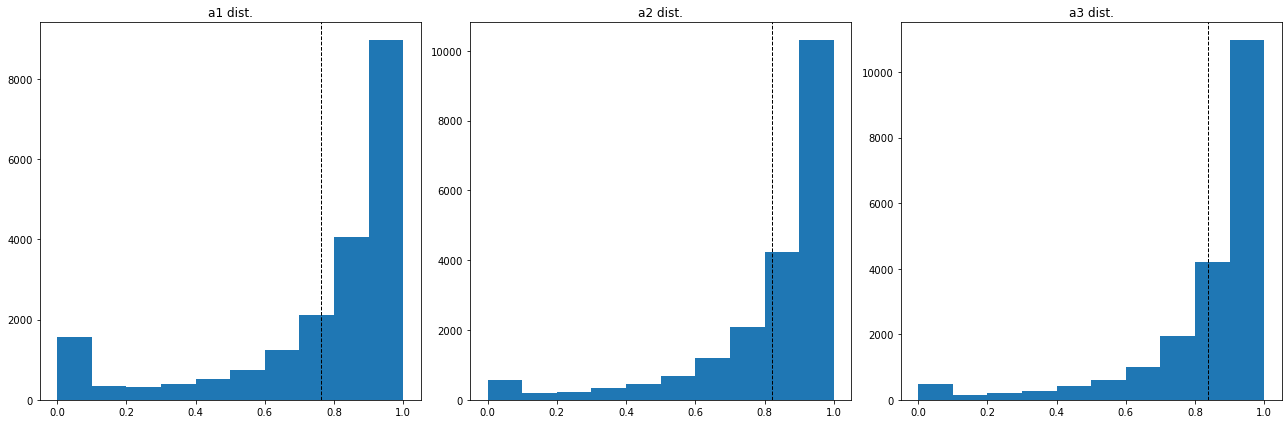

In [89]:
all_depth_scores = np.empty((0, 7))
for scene in scene_depth_scores:
    if len(scene_depth_scores[scene]) <= 0:
        continue
    all_depth_scores = np.concatenate([all_depth_scores, scene_depth_scores[scene]], axis=0)
    
print(all_depth_scores.shape)
with np.printoptions(precision=4, suppress=True):
    print(np.mean(all_depth_scores, axis=0))
    
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

for idx, label in enumerate(['a1', 'a2', 'a3']):
    ax[idx].hist(all_depth_scores[:, 4+idx])
    ax[idx].axvline(all_depth_scores[:, 4+idx].mean(), color='k', linestyle='dashed', linewidth=1)

    ax[idx].set_title(f'{label} dist.')

plt.tight_layout()
plt.show()

In [91]:
with open('/home/shantanu.singh/indoor-layout-estimation/splits/gibson/gibson_8fid_train.txt', 'r') as f:
    train_fps = f.read().splitlines()
    
with open('/home/shantanu.singh/indoor-layout-estimation/splits/gibson/gibson_8fid_val.txt', 'r') as f:
    val_fps = f.read().splitlines()
    
print(len(train_fps), len(val_fps))

12655 1548


In [93]:
split_depth_scores = {}
img_shape = (480, 480) 
bev_shape = (128, 128)
depth_range = (0.1, 10.0)

for split in ['train', 'val']:
    depth_scores = []
    fps = eval(f'{split}_fps')
    
    for fp in fps:
        scene, fileidx = fp.split()
        filename = f'{fileidx}.png'
        
        depth_fp = os.path.join(data_dir, scene, '0', 'left_depth', filename)
        sem_fp = os.path.join(data_dir, scene, '0', 'left_semantic', filename)
        
        depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
        floor_seg = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0

        width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
        depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
        depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
        floor_seg = cv2.resize(floor_seg, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
        floor_seg = floor_seg[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
            
        pred_depth = cv2.imread(os.path.join(pred_dir, scene, '0', 'pred_depth', filename), -1) / 6553.5
        pred_depth = cv2.resize(pred_depth, dsize=img_shape, interpolation=cv2.INTER_NEAREST)
        pred_depth = np.clip(pred_depth, a_min=depth_range[0], a_max=depth_range[1])

        mask = np.logical_and(floor_seg==1, depth>depth_range[0], depth<depth_range[1])
        
        if np.sum(mask) == 0:
            continue

        depth_scores.append(compute_errors(depth, pred_depth, mask))
        
    split_depth_scores[split] = np.array(depth_scores)

train 12655 [0.2196 0.3774 0.861  0.8232 0.812  0.8797 0.8979]
val 1548 [0.1718 0.2953 0.79   0.7903 0.8901 0.9005 0.9074]


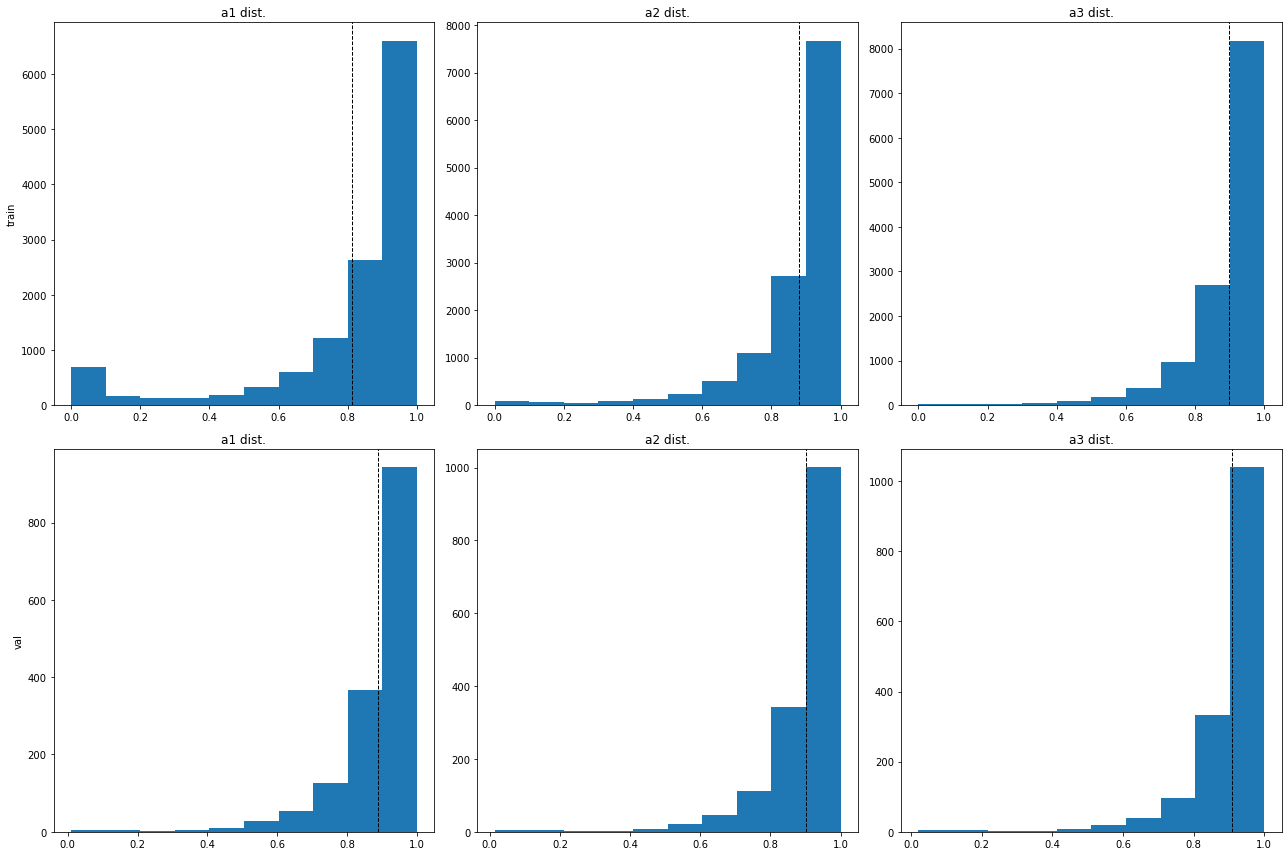

In [94]:
# mean depth score per split

with np.printoptions(precision=4, suppress=True):
    for split in split_depth_scores.keys():
        split_score = np.mean(split_depth_scores[split], axis=0)
        print(split, split_depth_scores[split].shape[0], split_score)
    
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))

for split_idx, split in enumerate(['train', 'val']):
    for ax_idx, label in enumerate(['a1', 'a2', 'a3']):
        ax[split_idx][ax_idx].hist(split_depth_scores[split][:, 4+ax_idx])
        ax[split_idx][ax_idx].axvline(split_depth_scores[split][:, 4+ax_idx].mean(), color='k', linestyle='dashed', linewidth=1)

        ax[split_idx][ax_idx].set_title(f'{label} dist.')
    ax[split_idx][0].set_ylabel(split)

plt.tight_layout()
plt.show()

In [30]:
# From the data_visualization notebook
def get_seg_map(depth, bev, K, offset_baseline=False, offset_camera_plane=False):
    baseline = 0.2
    cam_height = 1.0

    inv_K = np.linalg.inv(K[:3,:3])

    h, w = depth.shape

    img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

    pc = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc = pc.transpose((0,2,1)) * depth
    pc = pc.reshape((3, -1))

    pc = np.concatenate([pc, np.ones((1, h*w))], axis=0)

    bev_size = (3.2, 3.2) # m
    bev_res = bev_size[0] / bev.shape[0]
    
    cam_to_agent = np.eye(4)
    cam_to_agent[0, 3] = -0.1 * offset_baseline
    cam_to_agent[2, 3] = -0.1 * offset_camera_plane

    T = np.zeros((4, 4))
    T[0,0] = 1
    T[1,2] = -1
    T[2,1] = 1
    T[3,3] = 1
    T[0,3] = 1.6
    T[1,3] = 3.2

    ortho_cam_points = (T @ cam_to_agent @ pc) // bev_res
    valid = (ortho_cam_points[0] > 0) & (ortho_cam_points[0] < bev.shape[1]) & (ortho_cam_points[1] > 0) & (ortho_cam_points[1] < bev.shape[0]) & (ortho_cam_points[2] > 0)

    pt_bev_indices = (ortho_cam_points[1, valid]*bev.shape[1] + ortho_cam_points[0, valid]).astype(int)
    pt_bev_cls = np.take(bev.reshape(-1), pt_bev_indices)

    seg_map = np.zeros(w * h, dtype=np.uint8)
    seg_map[valid] = pt_bev_cls
    seg_map = seg_map.reshape((h, w))
    
    return seg_map

In [65]:
def prepare_plot(scene, idx, offset_baseline=False, offset_camera_plane=False, tgt_shape = (128, 128)):
    
    # tgt_shape - height, width

    rgb = cv2.cvtColor(cv2.imread(os.path.join(data_dir, scene, '0', 'left_rgb', f'{idx}.jpg'), -1), cv2.COLOR_BGR2RGB)
    depth = cv2.imread(os.path.join(data_dir, scene, '0', 'left_depth', f'{idx}.png'), -1).astype(np.float32)/6553.5
    semantics = cv2.imread(os.path.join(data_dir, scene, '0', 'left_semantic', f'{idx}.png'), -1)
    
    org_shape = depth.shape # height, width
    
    width_ar = int(rgb.shape[1] * tgt_shape[0] / rgb.shape[0])
    rgb = cv2.resize(rgb, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
    rgb = rgb[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
    depth = cv2.resize(depth, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
    depth = depth[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
    semantics = cv2.resize(semantics, dsize=(width_ar, tgt_shape[0]), interpolation=cv2.INTER_NEAREST)
    semantics = semantics[:tgt_shape[0], (width_ar - tgt_shape[1])//2 : (width_ar + tgt_shape[1])//2]
    
    
    hrnet_seg = (np.isin(semantics, floor_semantic_classes) + 1) * 127
    hrnet_seg_overlay = np.copy(rgb).astype(np.float32) / 255
    hrnet_seg_overlay *= 0.75
    hrnet_seg_overlay[hrnet_seg == 127, 0] *= 2
    hrnet_seg_overlay[hrnet_seg == 254, 1] *= 2
    hrnet_seg_overlay = np.clip(hrnet_seg_overlay, a_min=0, a_max=1)
    
   
    f = (org_shape[1] * tgt_shape[0]) / (2 * org_shape[0])

    K = camera_intrinsic_transform(f_x=f, c_x=tgt_shape[1]/2, f_y=f, c_y=tgt_shape[0]/2)

    
    if '0' in os.listdir(os.path.join(bev_dir, scene)):
        subdirs = os.listdir(os.path.join(bev_dir, scene, '0'))
        subdir = os.path.join('0', [dirname for dirname in subdirs if 'bev' in dirname][0])
    else:
        subdir = ''

    gt_bev = cv2.imread(os.path.join(bev_dir, scene, subdir, f'{idx}.png'), -1)
    gt_bev = cv2.resize(gt_bev, dsize=bev_size, interpolation=cv2.INTER_NEAREST)

    # Use bev from simulator to create floor segmentation map
    bev_seg = get_seg_map(depth, gt_bev, K, offset_baseline, offset_camera_plane)
    bev_seg_overlay = np.copy(rgb).astype(np.float32) / 255
    bev_seg_overlay *= 0.75
    bev_seg_overlay[bev_seg == 127, 0] *= 2
    bev_seg_overlay[bev_seg == 254, 1] *= 2
    bev_seg_overlay = np.clip(bev_seg_overlay, a_min=0, a_max=1)
    
    gt_bev = gt_bev // 254

    pred_bev = cv2.imread(os.path.join(pred_dir, scene, '0', 'pred_bev', f'{idx}.png'), -1) // 254
    pred_bev = cv2.resize(pred_bev, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    

    return (rgb, gt_bev, pred_bev, bev_seg_overlay, hrnet_seg_overlay)

def plot_images(imgs):
    title = ['rgb', 'gt_bev', 'pred_bev', 'bev_seg_overlay', 'hrnet_seg_overlay']
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(5*len(imgs), 5))
    
    for idx, ax in enumerate(axes):
        ax.imshow(imgs[idx])
        ax.set_title(title[idx], fontsize= 20)
        ax.axis('off')
        ax.margins(0)
    fig.tight_layout(pad=2)

    fig.canvas.draw()

    img = mplfig_to_npimage(fig)
    
    fig.clear()
    return img

In [66]:
# # COMPUTE HEAVY

# # sample (worst, average, best IOU(free) score images) per scene, ordered by median IOU(free) scores

# out_dir = '/scratch/shantanu/chandrakar_analysis'

# scene_order = sorted([scene for scene in scene_scores], key=lambda x: np.median(scene_scores[x][0, :, 1]))
# print(scene_order)

# sample_per_category = 5
# img_size = 6

# fig, axes = plt.subplots(ncols=6, nrows=sample_per_category, figsize=(6*img_size, sample_per_category*img_size))

# cols = ['', 'RGB', 'GT BEV', 'Chandrakar BEV', 'GT BEV Overlay', 'HRNet Seg Overlay']

# for scene in scene_order:
        
#     scores = scene_scores[scene]
#     ranks = np.argsort(scores[0, :, 1])
    
#     filenames = scene_filenames[scene]
    
#     indexes = {
#         'worst': sample_per_category//2,
#         'average': len(ranks)//2,
#         'best': len(ranks) - sample_per_category//2 - 1
#     }
    
#     for key, ref in indexes.items():
#         for ax in axes.flatten():
#             ax.clear()
        
#         for ax, col in zip(axes[0], cols):
#             ax.set_xlabel(col, rotation=0, fontdict={'fontsize':30})
#             ax.xaxis.set_label_position('top') 
            
#         for ax_idx, offset in enumerate(range(-(sample_per_category//2), sample_per_category//2 + 1)):
#             if offset >= sample_per_category:
#                 break

#             idx = int(ref + offset)
#             axes[ax_idx][0].text(0.5, 0.5, '{} {}\n non-free: {:.2f}\n free: {:.2f}'.format(scene, filenames[ranks[idx]], *scores[0, ranks[idx]]), 
#                               horizontalalignment='center', verticalalignment='center', 
#                               transform=axes[ax_idx][0].transAxes, fontdict={'fontsize':30})
#             axes[ax_idx][0].axis('off')
#             axes[ax_idx][0].margins(0)
                
#             imgs = prepare_plot(scene, ranks[idx])
#             for i, img in enumerate(imgs):
#                 axes[ax_idx][i+1].imshow(img)
#                 axes[ax_idx][i+1].axis('off')
#                 axes[ax_idx][i+1].margins(0)
        
#         fig.tight_layout(pad=2)
#         fig.canvas.draw()
                
#         save_path = os.path.join(out_dir, key, f'{scene}.png')
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
                
#         plt.savefig(save_path, facecolor='white', transparent=False)
        
# plt.close()

# Debug depth projection to bev

In [67]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [68]:
sys.path

['/home/shantanu.singh/indoor-layout-estimation/notebooks',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python37.zip',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/lib-dynload',
 '',
 '/home/shantanu.singh/.local/lib/python3.7/site-packages',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/site-packages',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/site-packages/deform_conv-0.0.0-py3.7-linux-x86_64.egg',
 '/home/shantanu.singh/indoor-layout-estimation/networks/stereo_depth/anynet/models/spn_t1',
 '/home/shantanu.singh/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/extensions',
 '/home/shantanu.singh/.ipython',
 '/home/shantanu.singh/indoor-layout-estimation']

In [69]:
if '/home/shantanu.singh/indoor-layout-estimation' not in sys.path:
    sys.path.append('/home/shantanu.singh/indoor-layout-estimation')

In [70]:
if 'networks.occant_baselines.depthsensor' in sys.modules:
    del sys.modules['networks.occant_baselines.depthsensor']

from networks.occant_baselines.depthsensor import DepthProjector
from configs.default import get_cfg_defaults

In [77]:
data_dir = '/scratch/shantanu/HabitatGibson/data/'
bev_dir = '/scratch/shantanu/HabitatGibson/bevs/sim' #'/scratch/shantanu/HabitatGibson/bevs/gtdepth/'
pred_dir = '/scratch/shantanu/results/chandrakar2'
bev_size = (128, 128)
tgt_shape = (480, 480)

In [78]:
scenes = os.listdir(data_dir)
print(scenes)

['Stockman', 'Darden', 'Hanson', 'Lakeville', 'Coffeen', 'Newfields', 'Lindenwood', 'Wainscott', 'Hiteman', 'Markleeville', 'Klickitat', 'Pomaria', 'Marstons', 'Wiconisco', 'Allensville', 'Collierville', 'Mifflinburg', 'Tolstoy', 'Woodbine', 'Beechwood', 'Pinesdale', 'Onaga', 'Corozal', 'Leonardo', 'Merom', 'Forkland', 'Ranchester', 'Cosmos', 'Shelbyville']


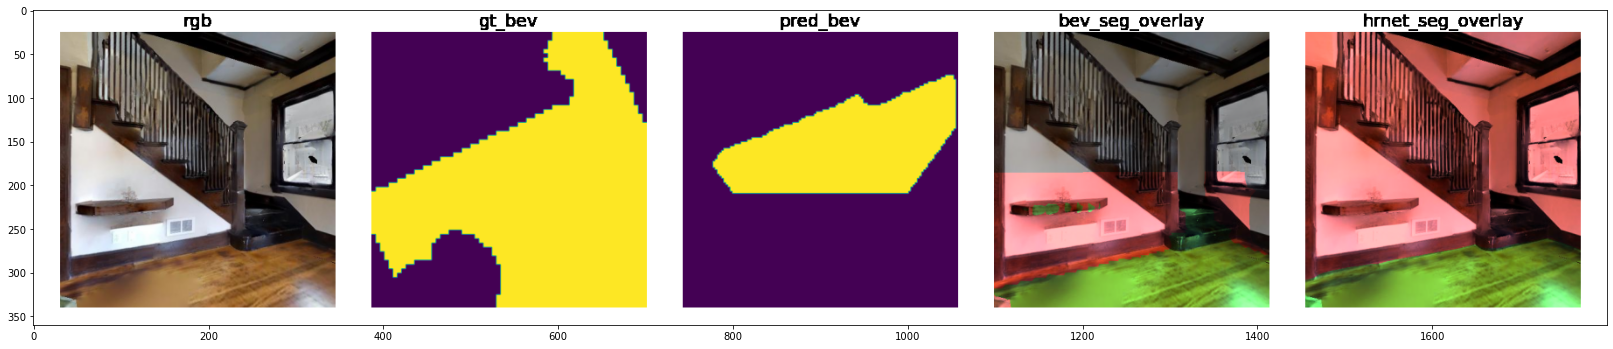

In [79]:
# scene = 'Tolstoy'
# idx = 230

scene = 'Mifflinburg'
idx = 33

plt.imshow(plot_images(prepare_plot(scene, idx, offset_baseline=False, offset_camera_plane=False, tgt_shape=tgt_shape)))

In [90]:
gtdepth = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/gtdepth/{scene}/0/bev/{idx}.png', -1)
sim = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/sim/{scene}/0/bev/{idx}.png', -1)
sim[0,0] = 0

depth = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/left_depth/{idx}.png', -1).astype(np.float32)/6553.5
rgb = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/left_rgb/{idx}.jpg', -1)

chandrakar = cv2.imread(f'/scratch/shantanu/results/chandrakar2/{scene}/0/pred_bev/{idx}.png', -1)

gtdepth = cv2.resize(gtdepth, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
sim = cv2.resize(sim, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
chandrakar = cv2.resize(chandrakar, dsize=bev_size, interpolation=cv2.INTER_NEAREST)

# gtdepth[:, :-4] = gtdepth[:, 4:]
# gtdepth[4:, :] = gtdepth[:-4, :]

# gtdepth[:, -4:] = 0
# gtdepth[:4, :] = 0

Text(0.5, 1.0, 'False occupied')

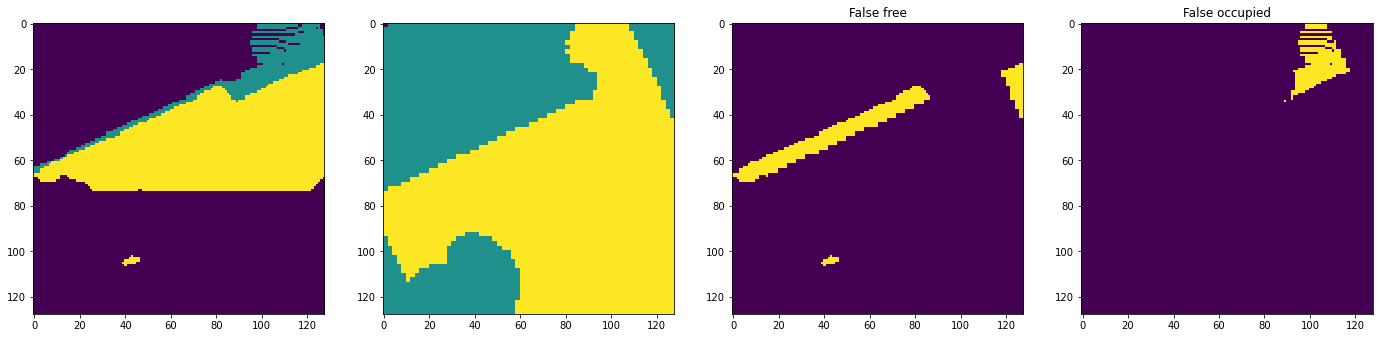

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(24, 6))
ax[0].imshow(gtdepth, interpolation='None')
ax[1].imshow(sim, interpolation='None')
ax[2].imshow(np.logical_and(gtdepth==254, sim==127), interpolation='None')
ax[2].set_title('False free')
ax[3].imshow(np.logical_and(gtdepth==127, sim==254), interpolation='None')
ax[3].set_title('False occupied')

In [92]:
cfg = get_cfg_defaults()
cfg.merge_from_file('/home/shantanu.singh/indoor-layout-estimation/configs/train_occant.yaml')
cfg.dilate_maps = False
cfg.offset_baseline = False
cfg.offset_camera_plane = False

dp = DepthProjector(cfg)

In [93]:
scale_width = int(depth.shape[1] * cfg.height / depth.shape[0])
scaled_depth = cv2.resize(depth, dsize=(scale_width, cfg.height), interpolation=cv2.INTER_NEAREST)
cropped_depth = scaled_depth[: cfg.height, (scale_width - cfg.height)//2 : (scale_width + cfg.height)//2]
bev_proj_2ch = dp.get_depth_projection(cropped_depth)

bev_proj = np.zeros_like(sim)
bev_proj[np.logical_and(bev_proj_2ch[..., 0] == 1, bev_proj_2ch[..., 1] == 1)] = 127
bev_proj[np.logical_and(bev_proj_2ch[..., 0] == 0, bev_proj_2ch[..., 1] == 1)] = 254

In [94]:
# Compute IOU scores while ignoring unknown indices in proj_bev
# Occupied(127) - 0, Free(254) - 1, Unknown(0) - 2 (Ignore this index by setting n_classes=2 [0, 1])
def calc_IU(src, tgt):
    map1 = np.zeros_like(src)
    map1[src==254] = 1
    map1[src==0] = 2

    map2 = np.zeros_like(tgt)
    map2[tgt==254] = 1
    map2[tgt==0] = 2
    map2[src==0] = 2  # Ignore the unknown indices on sim map as well by setting them to class 2.
    
    return mean_IU(map1, map2, 2)

IU_score = calc_IU(bev_proj, sim)
print('Proj_Bev/Sim Occ: {:.2f} Free: {:.2f}'.format(*IU_score))
    
IU_score = calc_IU(chandrakar, sim)
print('Chandrakar/Sim Occ: {:.2f} Free: {:.2f}'.format(*IU_score))

IU_score = calc_IU(chandrakar, bev_proj)
print('Chandrakar/Proj_Bev Occ: {:.2f} Free: {:.2f}'.format(*IU_score))

Proj_Bev/Sim Occ: 0.57 Free: 0.88
Chandrakar/Sim Occ: 0.00 Free: 0.82
Chandrakar/Proj_Bev Occ: 0.00 Free: 0.60


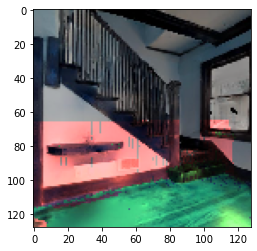

In [95]:
K = camera_intrinsic_transform(f_x=85.33, c_x=64, f_y=85.33, c_y=64)
bev_seg = get_seg_map(cropped_depth, bev_proj, K, offset_baseline=False, offset_camera_plane=False)

scaled_rgb = cv2.resize(rgb, dsize=(scale_width, cfg.height), interpolation=cv2.INTER_NEAREST)
cropped_rgb = scaled_rgb[: cfg.height, (scale_width - cfg.height)//2 : (scale_width + cfg.height)//2]

bev_seg_overlay = np.copy(cropped_rgb).astype(np.float32) / 255
bev_seg_overlay *= 0.75
bev_seg_overlay[bev_seg == 127, 0] *= 2
bev_seg_overlay[bev_seg == 254, 1] *= 2
bev_seg_overlay = np.clip(bev_seg_overlay, a_min=0, a_max=1)
plt.imshow(bev_seg_overlay)

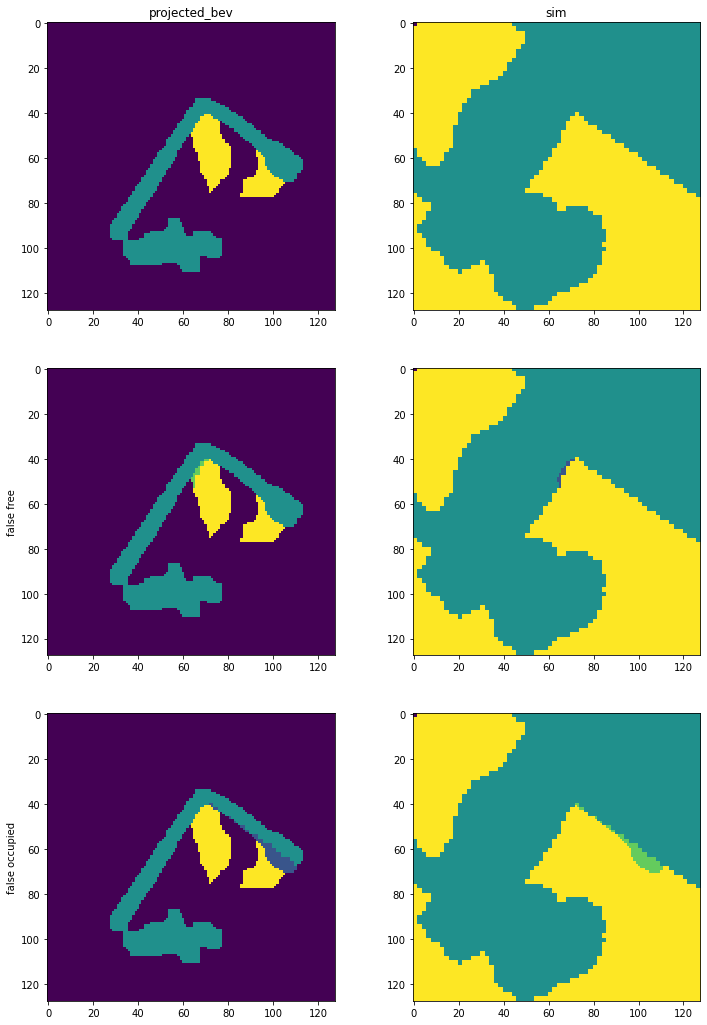

In [165]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
ax = axes.flatten()
ax[0].imshow(bev_proj, interpolation='None')
ax[1].imshow(sim, interpolation='None')

ax[0].set_title('projected_bev')
ax[1].set_title('sim')
# ax[2].imshow(np.logical_and(bev_proj==254, sim==127), interpolation='None')

match_idx = np.logical_and(bev_proj==254, sim==127)
match1 = np.copy(bev_proj)
match1[match_idx] -= 60
ax[2].imshow(match1, interpolation='None')
ax[2].set_ylabel('false free')

match2 = np.copy(sim)
match2[match_idx] -= 60
ax[3].imshow(match2, interpolation='None')


match_idx = np.logical_and(bev_proj==127, sim==254)
match1 = np.copy(bev_proj)
match1[match_idx] -= 60
ax[4].imshow(match1, interpolation='None')
ax[4].set_ylabel('false occupied')

match2 = np.copy(sim)
match2[match_idx] -= 60
ax[5].imshow(match2, interpolation='None')

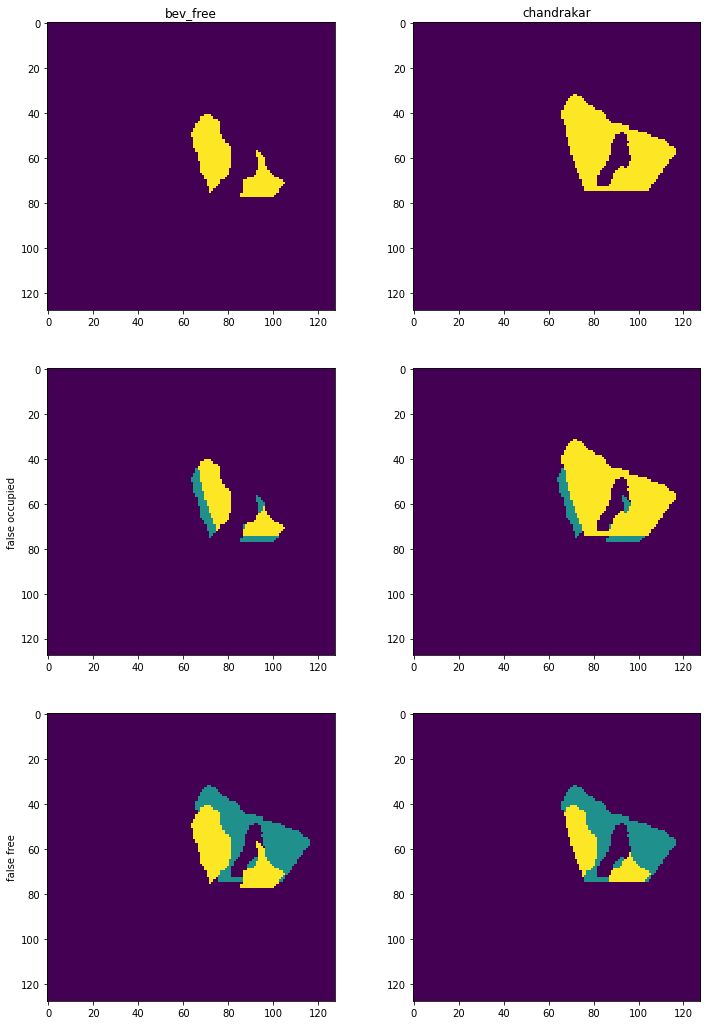

In [166]:
bev_free = (bev_proj == 254) * 254

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
ax = axes.flatten()
ax[0].imshow(bev_free, interpolation='None')
ax[1].imshow(chandrakar, interpolation='None')

ax[0].set_title('bev_free')
ax[1].set_title('chandrakar')

# ax[2].imshow(np.logical_and(bev_free==254, chandrakar==0), interpolation='None')
# ax[3].imshow(np.logical_and(bev_free==0, chandrakar==254), interpolation='None')


match_idx = np.logical_and(bev_free==254, chandrakar==0)
match1 = np.copy(bev_free)
match1[match_idx] = 127
ax[2].imshow(match1, interpolation='None')
ax[2].set_ylabel('false occupied')

match2 = np.copy(chandrakar)
match2[match_idx] = 127
ax[3].imshow(match2, interpolation='None')


match_idx = np.logical_and(bev_free==0, chandrakar==254)
match1 = np.copy(bev_free)
match1[match_idx] = 127
ax[4].imshow(match1, interpolation='None')
ax[4].set_ylabel('false free')

match2 = np.copy(chandrakar)
match2[match_idx] = 127
ax[5].imshow(match2, interpolation='None')

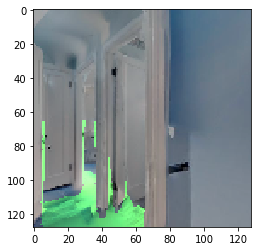

In [146]:
K = np.zeros((4,4))
K[0,0] = 85.33
K[1,1] = 85.33
K[0,2] = 64
K[1,2] = 64
K[2,2] = 1
K[3,3] = 1

bev_seg = get_seg_map(cropped_depth, chandrakar, K, offset_baseline=False, offset_camera_plane=False)

scale_width = int(rgb.shape[1] * cfg.height / rgb.shape[0])
scaled_rgb = cv2.resize(rgb, dsize=(scale_width, cfg.height), interpolation=cv2.INTER_NEAREST)
cropped_rgb = scaled_rgb[: cfg.height, (scale_width - cfg.height)//2 : (scale_width + cfg.height)//2]

bev_seg_overlay = np.copy(cropped_rgb).astype(np.float32) / 255
bev_seg_overlay *= 0.75
bev_seg_overlay[bev_seg == 127, 0] *= 2
bev_seg_overlay[bev_seg == 254, 1] *= 2
bev_seg_overlay = np.clip(bev_seg_overlay, a_min=0, a_max=1)
plt.imshow(bev_seg_overlay, interpolation='None')

### Qualitative exps

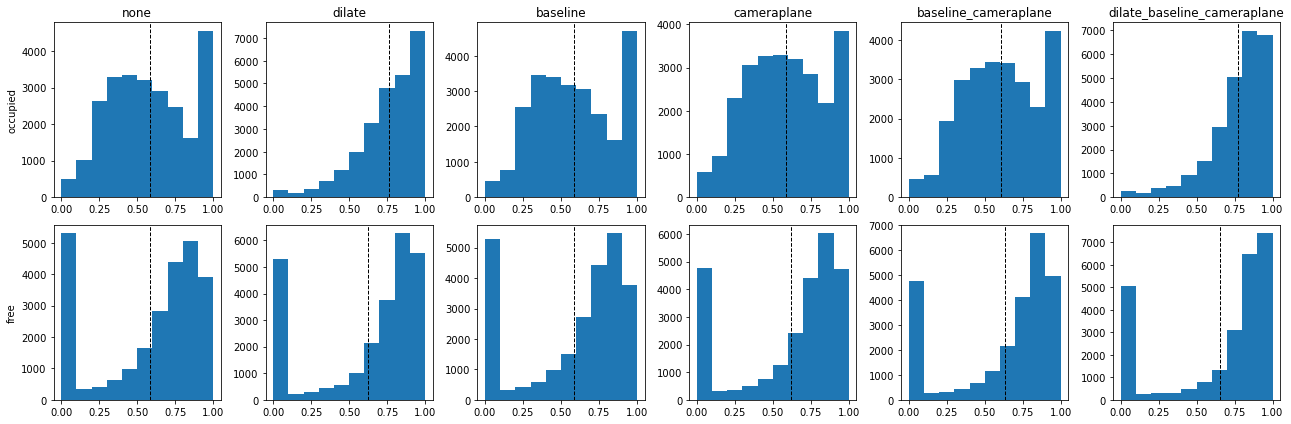

In [225]:
# dilate_maps, offset_baseline, offset_camera_plane
params = dict(
    none=(False, False, False),
    dilate=(True, False, False),
    baseline=(False, True, False),
    cameraplane=(False, False, True),
    baseline_cameraplane=(False, True, True),
    dilate_baseline_cameraplane=(True, True, True),
)

cfg = get_cfg_defaults()
cfg.merge_from_file('/home/shantanu.singh/indoor-layout-estimation/configs/train_occant.yaml')

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(6*3, 2*3))

param_IU_scores = {}

for param_idx, key in enumerate(params.keys()):
    cfg.dilate_maps = params[key][0]
    cfg.offset_baseline = params[key][1]
    cfg.offset_camera_plane = params[key][2]

    dp = DepthProjector(cfg)
    
    IU_scores = {}
    
    for scene in scenes:
        filenames = sorted(os.listdir(os.path.join(bev_dir, scene, '0', 'bev')), 
                           key=lambda x: int(os.path.splitext(x)[0]))
        scene_IU = []
        for filename in filenames:
            sim = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/sim/{scene}/0/bev/{filename}', -1)
            sim = cv2.resize(sim, dsize=(cfg.bev_width, cfg.bev_height), interpolation=cv2.INTER_NEAREST)

            depth = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/left_depth/{filename}', -1).astype(np.float32)/6553.5
            width_ar = int(depth.shape[1] * cfg.height / depth.shape[0])
            depth = cv2.resize(depth, dsize=(width_ar, cfg.height), interpolation=cv2.INTER_NEAREST)
            depth = depth[:cfg.height, (width_ar - cfg.width)//2 : (width_ar + cfg.width)//2]


            scale_width = int(depth.shape[1] * cfg.height / depth.shape[0])
            scaled_depth = cv2.resize(depth, dsize=(scale_width, cfg.height), interpolation=cv2.INTER_NEAREST)
            cropped_depth = scaled_depth[: cfg.height, (scale_width - cfg.height)//2 : (scale_width + cfg.height)//2]
            bev_proj_2ch = dp.get_depth_projection(cropped_depth)

            bev_proj = np.zeros_like(sim)
            bev_proj[np.logical_and(bev_proj_2ch[..., 0] == 1, bev_proj_2ch[..., 1] == 1)] = 127
            bev_proj[np.logical_and(bev_proj_2ch[..., 0] == 0, bev_proj_2ch[..., 1] == 1)] = 254

            scene_IU.append(calc_IU(bev_proj, sim))

        IU_scores[scene] = np.array(scene_IU)
    
    param_IU_scores[key] = IU_scores
    
    all_param_scores = []
    [all_param_scores.extend(val) for val in IU_scores.values()]
    all_param_scores = np.array(all_param_scores)
    
    axes[0][param_idx].hist(all_param_scores[:, 0])
    axes[0][param_idx].axvline(all_param_scores[:, 0].mean(), color='k', linestyle='dashed', linewidth=1)
    axes[1][param_idx].hist(all_param_scores[:, 1])
    axes[1][param_idx].axvline(all_param_scores[:, 1].mean(), color='k', linestyle='dashed', linewidth=1)
    
    axes[0][param_idx].set_title(key)
    

axes[0][0].set_ylabel('occupied')
axes[1][0].set_ylabel('free')

plt.tight_layout()
plt.show()

np.save('depth_projection_param_exps.npy', param_IU_scores)

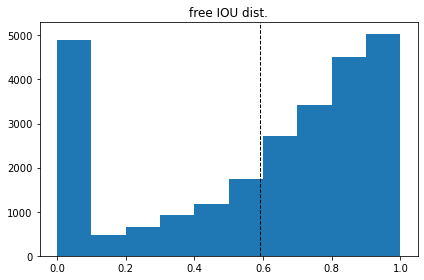

In [151]:
cfg = get_cfg_defaults()
cfg.merge_from_file('/home/shantanu.singh/indoor-layout-estimation/configs/train_occant.yaml')


IU_scores = {}

for scene in scenes:
    filenames = sorted(os.listdir(os.path.join(bev_dir, scene, '0', 'bev')), 
                       key=lambda x: int(os.path.splitext(x)[0]))
    scene_IU = []
    for filename in filenames:
        tgtbev = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/partial_occupancy/{scene}/{filename}', -1)
        tgtbev = cv2.resize(tgtbev, dsize=(cfg.bev_width, cfg.bev_height), interpolation=cv2.INTER_NEAREST)

        pred_bev = cv2.imread(f'/scratch/shantanu/results/chandrakar2/{scene}/0/pred_bev/{filename}', -1)
        pred_bev = cv2.resize(pred_bev, dsize=(cfg.bev_width, cfg.bev_height), interpolation=cv2.INTER_NEAREST)
        scene_IU.append(calc_IU(pred_bev, tgtbev))

    IU_scores[scene] = np.array(scene_IU)
    
    
all_scores = []
[all_scores.extend(val) for val in IU_scores.values()]
all_scores = np.array(all_scores)

fig = plt.figure()
ax = plt.gca()

ax.hist(all_scores[:, 1])
ax.axvline(all_scores[:, 1].mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title('free IOU dist.')

plt.tight_layout()
plt.show()

np.save('chandrakar_param_exps.npy', IU_scores)

## Compare HRNet v2 and Mobilenet for segmentation

In [12]:
data_dir = '/scratch/shantanu/gibson4/new'
bev_dir = '/scratch/shantanu/gibson4/dilated_partialmaps'
hrnet_sem_dir = '/scratch/shantanu/gibson4/semantics'
mb_sem_dir = '/scratch/shantanu/gibson4/mbnet_semantics/'

print(os.listdir(data_dir))

['Delton', 'Andover', 'Brevort', 'Soldier', 'Scottsmoor', 'Mosquito', 'Nuevo', 'Stilwell', 'Spencerville', 'Sumas', 'Parole', 'Convoy', 'Sargents', 'Albertville', 'Elmira', 'Superior', 'Roane', 'Seward', 'Hambleton', 'Annawan', 'Shelbiana', 'Eagerville', 'Nemacolin', 'Anaheim', 'Sanctuary', 'Angiola', 'Oyens', 'Silas', 'Azusa', 'Reyno', 'Greigsville', 'Stanleyville', 'Roxboro', 'Bolton', 'Rosser', 'Colebrook', 'Arkansaw', 'Ribera', 'Pettigrew', 'Hillsdale', 'Nimmons', 'Spotswood', 'Pleasant', 'Springhill', 'Goffs', 'Mosinee', 'Roeville', 'Swormville', 'Mifflintown', 'Applewold', 'Pablo', 'Ballou', 'Adrian', 'Haxtun', 'Denmark', 'Nicut', 'Maryhill', 'Sasakwa', 'Mesic', 'Sisters', 'Avonia', 'Hometown', 'Eudora', 'Woonsocket', 'Edgemere', 'Crandon', 'Bowlus', 'Dryville', 'Dunmor', 'Hainesburg', 'Micanopy', 'Cantwell', 'Mobridge', 'Stokes', 'Scioto', 'Placida', 'Beach', 'Cooperstown', 'Sands', 'Quantico', 'Sawpit', 'Sodaville', 'Eastville', 'Hominy', 'Kerrtown', 'Rancocas', 'Capistrano', '

In [13]:
floor_semantic_classes = (3, 28)

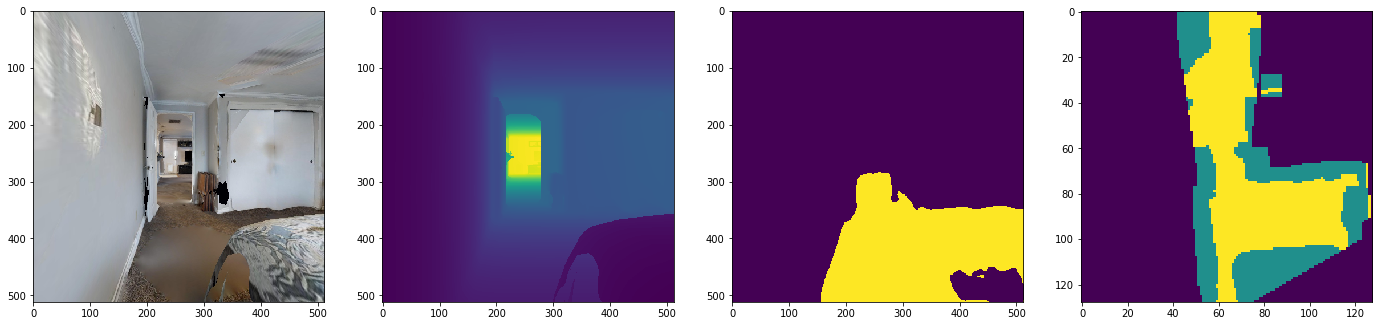

In [9]:
scene = 'Eastville'
fileidx = 100
pose = 'front'

img_shape = (512, 512) #(128, 128) # w, h
bev_shape = (128, 128)

rgb_fp = os.path.join(data_dir, scene, '0', pose, 'RGB', f'{fileidx}.jpg')
depth_fp = os.path.join(data_dir, scene, '0', pose, 'DEPTH', f'{fileidx}.png')
sem_fp = os.path.join(sem_dir, scene, '0', pose, 'semantics', f'{fileidx}.png')
bev_fp = os.path.join(bev_dir, scene, pose, 'partial_occ', f'{fileidx}.png')

rgb = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5
sem = np.isin(cv2.imread(sem_fp, -1), floor_semantic_classes) * 1.0
bev = cv2.imread(bev_fp, -1)

width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
rgb = cv2.resize(rgb, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
rgb = rgb[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
sem = cv2.resize(sem, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
sem = sem[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
bev = cv2.resize(bev, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)


fig, ax = plt.subplots(ncols=4, figsize=(24, 6))
ax[0].imshow(rgb, interpolation='NEAREST')
ax[1].imshow(depth, interpolation='NEAREST')
ax[2].imshow(sem, interpolation='NEAREST')
ax[3].imshow(bev, interpolation='NEAREST')

In [11]:
with open('../splits/gibson4/filtered_front_train_files.txt', 'r') as f:
    train_fps = f.read().splitlines()
    
with open('../splits/gibson4/filtered_front_val_files.txt', 'r') as f:
    val_fps = f.read().splitlines()
    
print(len(train_fps), len(val_fps))

18436 2955


In [39]:
def f1score(eval_segm, gt_segm, n_cl):

    check_size(eval_segm, gt_segm)
    # cl, n_cl = extract_classes(gt_segm)
    cl = np.arange(n_cl)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)
    f1 = [0] * n_cl
    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        n_ij = np.sum(curr_eval_mask) + np.sum(curr_gt_mask)
        if n_ij == 0 and np.sum(curr_gt_mask) == 0:
            f1[i] = 0
        else:
            f1[i] = 2 * n_ii / (float(n_ij) + 1e-6)  #  2 * int(A,B) / (n(A) + n(B))
    return f1

In [40]:
split_IU_scores = {}
split_F1_scores = {}

img_shape = (512, 512) 

for split in ['train', 'val']:
    IU_scores = []
    F1_scores = []
    fps = eval(f'{split}_fps')
    
    for fp in fps:
        scene, pose, fileidx = fp.split()
        filename = f'{fileidx}.png'

        rgb_fp = os.path.join(data_dir, scene, '0', pose, 'RGB', f'{fileidx}.jpg')
        hrnet_sem_fp = os.path.join(hrnet_sem_dir, scene, '0', pose, 'semantics', f'{fileidx}.png')
        mb_sem_fp = os.path.join(mb_sem_dir, scene, '0', pose, 'RGB', f'{fileidx}.png')

        floor_hrnet = np.isin(cv2.imread(hrnet_sem_fp, -1), floor_semantic_classes) * 1.0
        floor_mbnet = np.isin(cv2.imread(mb_sem_fp, -1), floor_semantic_classes) * 1.0

        floor_hrnet = cv2.resize(floor_hrnet, dsize=img_shape, interpolation=cv2.INTER_NEAREST)
        floor_mbnet = cv2.resize(floor_mbnet, dsize=img_shape, interpolation=cv2.INTER_NEAREST)

        IU_scores.append(mean_IU(floor_mbnet, floor_hrnet, 2))
        F1_scores.append(f1score(floor_mbnet, floor_hrnet, 2))
        
    split_IU_scores[split] = np.array(IU_scores)
    split_F1_scores[split] = np.array(F1_scores)

In [41]:
split_IU_scores['train'].mean(axis=0), split_IU_scores['val'].mean(axis=0)

(array([0.98006323, 0.83068376]), array([0.97909051, 0.81366376]))

In [42]:
split_F1_scores['train'].mean(axis=0), split_F1_scores['val'].mean(axis=0)

(array([0.98973489, 0.87294058]), array([0.98927702, 0.86193133]))

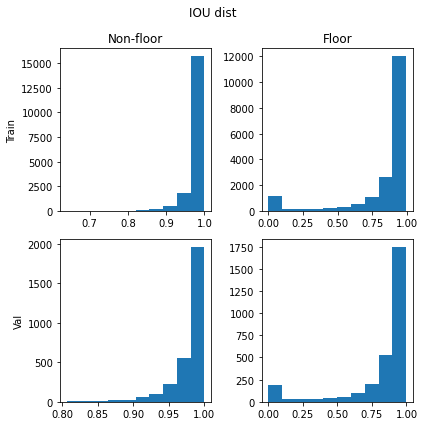

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

ax[0][0].hist(split_IU_scores['train'][:, 0])
ax[0][1].hist(split_IU_scores['train'][:, 1])
ax[1][0].hist(split_IU_scores['val'][:, 0])
ax[1][1].hist(split_IU_scores['val'][:, 1])


ax[0][0].set_title('Non-floor')
ax[0][1].set_title('Floor')
ax[0][0].set_ylabel('Train')
ax[1][0].set_ylabel('Val')

plt.suptitle('IOU dist')
plt.tight_layout()
plt.show()

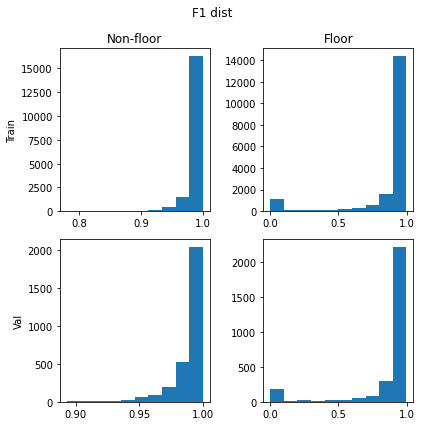

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

ax[0][0].hist(split_F1_scores['train'][:, 0])
ax[0][1].hist(split_F1_scores['train'][:, 1])
ax[1][0].hist(split_F1_scores['val'][:, 0])
ax[1][1].hist(split_F1_scores['val'][:, 1])


ax[0][0].set_title('Non-floor')
ax[0][1].set_title('Floor')
ax[0][0].set_ylabel('Train')
ax[1][0].set_ylabel('Val')

plt.suptitle('F1 dist')
plt.tight_layout()
plt.show()

In [51]:
pct_train = np.sum(split_IU_scores['train'][:, 1] < 0.5) / split_IU_scores['train'].shape[0]
pct_val = np.sum(split_IU_scores['val'][:, 1] < 0.5) / split_IU_scores['val'].shape[0]

pct_train, pct_val

(0.09947927967021046, 0.1093062605752961)

In [52]:
pct_train = np.sum(split_F1_scores['train'][:, 1] < 0.5) / split_F1_scores['train'].shape[0]
pct_val = np.sum(split_F1_scores['val'][:, 1] < 0.5) / split_F1_scores['val'].shape[0]

pct_train, pct_val

(0.08163376003471469, 0.08730964467005076)